# 画像の分類

【動物の画像分類】
animal_names = ['パンダ', 'ゾウ', 'ホッキョクグマ', 'ゴリラ', 'トラ', 'ペンギン', 'フラミンゴ', 'ハシビロコウ', 'サル', 'キリン', 'サイ', 'アシカ', 'カワウソ', 'カバ',  'ワニ',  'ライオン', 'カンガルー', 'シマウマ', 'アザラシ', 'レッサーパンダ']

＜アドバイス＞
- 「VGG16」など、画像認識で有名なモデルを参考にするとよい。
- 「out of memory」とエラーなった場合は、「すべてのランタイムをリセット」で再起動。
- 最近だと「convolution → batchnormalization → relu」がセットで使われることが多い。
- convolutionのin_channelsは「None」でOK
- batchnormalizationの引数は受け取るchannel数を入れる。


## 問題設定
指定の動物画像をCNNで分類し、検証データに対する精度を60%以上に引き上げる

## 実行準備

In [1]:
# GoogleDriveのマウント
from google.colab import drive
drive.mount('/content/drive')
# しっかりと認識されていることを確認する
!ls 'drive/My Drive/kikagaku/longterm/UenoAnimalClassification'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
animal_image_scrape.ipynb  images	   w6_sawada.ipynb
image_resize_test.ipynb    images_test	   w6_sawada_small.ipynb
image_resize_this.ipynb    resized_images


In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import chainer
import chainer.links as L
import chainer.functions as F
import cupy
print('GPU availability:', chainer.cuda.available)
print('cuDNN availability:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availability: True



## データの準備

In [3]:
# 動物の名前
animal_names = ['パンダ', 'ゾウ', 'ホッキョクグマ', 'ゴリラ', 'トラ', 'ペンギン', 'フラミンゴ', 'ハシビロコウ', 'サル', 'キリン', 'サイ', 'アシカ', 'カワウソ', 'カバ', 'ワニ', 'ライオン', 'カンガルー', 'シマウマ', 'アザラシ', 'レッサーパンダ']

# ファイルパスを取得
from glob import glob
filepaths = list()
for name in animal_names:
    data_dir = "drive/My Drive/kikagaku/longterm/UenoAnimalClassification/resized_images/"
    file_path = data_dir + name + '/*'
    animal_filepaths = glob(file_path)
    
    #ファイルパスを一つのリストに結合
    filepaths += animal_filepaths
print(filepaths)

['drive/My Drive/kikagaku/longterm/UenoAnimalClassification/resized_images/パンダ/resized_パンダ0.jpg', 'drive/My Drive/kikagaku/longterm/UenoAnimalClassification/resized_images/パンダ/resized_パンダ1.jpg', 'drive/My Drive/kikagaku/longterm/UenoAnimalClassification/resized_images/パンダ/resized_パンダ2.jpg', 'drive/My Drive/kikagaku/longterm/UenoAnimalClassification/resized_images/パンダ/resized_パンダ3.jpg', 'drive/My Drive/kikagaku/longterm/UenoAnimalClassification/resized_images/パンダ/resized_パンダ4.jpg', 'drive/My Drive/kikagaku/longterm/UenoAnimalClassification/resized_images/パンダ/resized_パンダ32.jpg', 'drive/My Drive/kikagaku/longterm/UenoAnimalClassification/resized_images/パンダ/resized_パンダ5.jpg', 'drive/My Drive/kikagaku/longterm/UenoAnimalClassification/resized_images/パンダ/resized_パンダ96.jpg', 'drive/My Drive/kikagaku/longterm/UenoAnimalClassification/resized_images/パンダ/resized_パンダ33.jpg', 'drive/My Drive/kikagaku/longterm/UenoAnimalClassification/resized_images/パンダ/resized_パンダ6.jpg', 'drive

In [4]:
len(animal_names)

20

In [5]:
# LabeledImageDatasetの適応するためにデータを形成
labeled_images = []

for filepath in filepaths:
    for i in range(len(animal_names)):
        if animal_names[i] in filepath:
            labeled_images.append((filepath, i))
labeled_images[:5]

[('drive/My Drive/kikagaku/longterm/UenoAnimalClassification/resized_images/パンダ/resized_パンダ0.jpg',
  0),
 ('drive/My Drive/kikagaku/longterm/UenoAnimalClassification/resized_images/パンダ/resized_パンダ1.jpg',
  0),
 ('drive/My Drive/kikagaku/longterm/UenoAnimalClassification/resized_images/パンダ/resized_パンダ2.jpg',
  0),
 ('drive/My Drive/kikagaku/longterm/UenoAnimalClassification/resized_images/パンダ/resized_パンダ3.jpg',
  0),
 ('drive/My Drive/kikagaku/longterm/UenoAnimalClassification/resized_images/パンダ/resized_パンダ4.jpg',
  0)]

In [6]:
print(len(labeled_images))
print(int(len(labeled_images)*0.7))
print(len(labeled_images)*0.7)
print(len(labeled_images) - int(len(labeled_images)*0.7))


3164
2214
2214.7999999999997
950


In [0]:
# データの分割
import random
random.seed(0)
random.shuffle(labeled_images)
train_num = int(len(labeled_images) * 0.7)
test_num = len(labeled_images) - train_num
_train = labeled_images[:train_num]
_test = labeled_images[train_num:]

# LabeledImageDatasetを適応
from chainer.datasets import LabeledImageDataset
train = LabeledImageDataset(_train)
test = LabeledImageDataset(_test)

In [8]:
print(len(train))
print(len(test))

2214
950


## モデルの定義

In [0]:
class CNN(chainer.Chain):

    def __init__(self, n_mid_1=1000, n_mid_2=100, n_mid_3=20, n_out=20):
        super().__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=3, out_channels=6, ksize=3, stride=1, pad=1) # (3, 224, 224) => (6, 112, 112)
            self.bn1 = L.BatchNormalization(6)
            self.conv2 = L.Convolution2D(in_channels=None, out_channels=12, ksize=3, stride=1, pad=1) # (6, 112, 112) => (12, 56, 56)
            self.bn2 = L.BatchNormalization(12)
            self.conv3 = L.Convolution2D(in_channels=None, out_channels=24, ksize=3, stride=1, pad=1) # (12, 56, 56) => (24, 28, 28)
            self.bn3 = L.BatchNormalization(24)
            self.conv4 = L.Convolution2D(in_channels=None, out_channels=48, ksize=3, stride=1, pad=1) # (24, 28, 28) => (48, 14, 14)
            self.bn4 = L.BatchNormalization(48)
            self.fc1 = L.Linear(None, n_mid_1)
            self.fc2 = L.Linear(None, n_mid_2)
            self.fc3 = L.Linear(None, n_mid_3)
            self.fc4 = L.Linear(None, n_out)

    def __call__(self, x):
        h = self.conv1(x)
        h = F.relu(self.bn1(h))
        h = F.max_pooling_2d(h, 2, 2)
        h = self.conv2(h)
        h = F.relu(self.bn2(h))
        h = F.max_pooling_2d(h, 2, 2)
        h = self.conv3(h)
        h = F.relu(self.bn3(h))
        h = F.max_pooling_2d(h, 2, 2)
        h = self.fc1(h)
        h = self.fc2(h)
        h = self.fc3(h)
        h = self.fc4(h)
        return h

In [0]:
import random

def reset_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    if chainer.cuda.available:
        chainer.cuda.cupy.random.seed(seed)

In [0]:
reset_seed(0)

In [0]:
# インスタンス化
cnn = CNN()
# cnn = VGG()

In [0]:
model = L.Classifier(cnn) 

GPUを使う場合は、modelをGPUへ転送しておく。

In [14]:
gpu_id = 0 # 使用したGPUに割り振られているID
model.to_gpu(gpu_id)

In [15]:
# GPU使用状況の確認
!nvidia-smi

Sat Jul 13 09:40:37 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    28W /  70W |    145MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [16]:
# Optimizerの定義とmodelとの紐づけ
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [0]:
batchsize = 20
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

In [0]:
from chainer import training
from chainer.training import extensions

epoch = 30

updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

trainer = training.Trainer(updater, (epoch, 'epoch'), out='drive/My Drive/kikagaku/longterm/UenoAnimalClassfication/result')

# バリデーション用のデータで評価
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))

# 学習結果の途中を表示する
trainer.extend(extensions.LogReport(trigger=(1, 'epoch'), log_name='animal_CNN0713'))

# １エポックごとに結果をlogファイルに出力させる
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

In [19]:
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.146847       0.161458                  24.6045     7.03942               610.576       
2           0.355405       0.301042                  3.23499     3.42118               621.067       
3           0.561261       0.273958                  1.57802     3.7173                631.199       
4           0.635          0.321875                  1.23481     3.83549               641.263       
5           0.719369       0.377083                  0.945433    3.38655               651.333       
6           0.775676       0.372917                  0.700583    3.67367               661.313       
7           0.767728       0.365625                  0.783741    4.06111               671.302       
8           0.810811       0.378125                  0.650921    3.97919               681.385       
9           0.799099       0.354167                  0.738613    5.04112            

In [20]:
# GPU使用状況の確認
!nvidia-smi

Sat Jul 13 09:55:55 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |    943MiB / 15079MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [24]:
import json
import pandas as pd
with open('drive/My Drive/kikagaku/longterm/UenoAnimalClassfication/result/animal_CNN0713') as f:
    result = pd.DataFrame(json.load(f))

# 結果の表示
result

,elapsed_time,epoch,iteration,main/accuracy,main/loss,validation/main/accuracy,validation/main/loss
0,610.576272,1,111,0.146847,24.604490,0.161458,7.039423
1,621.067199,2,222,0.355405,3.234988,0.301042,3.421177
2,631.199486,3,333,0.561261,1.578021,0.273958,3.717303
3,641.263436,4,443,0.635000,1.234806,0.321875,3.835487
4,651.332931,5,554,0.719369,0.945433,0.377083,3.386547
5,661.313052,6,665,0.775676,0.700583,0.372917,3.673672
6,671.301510,7,775,0.767728,0.783741,0.365625,4.061110
7,681.385085,8,886,0.810811,0.650921,0.378125,3.979190
8,691.232320,9,997,0.799099,0.738613,0.354167,5.041121
9,701.044577,10,1107,0.770909,1.027567,0.372917,5.366870


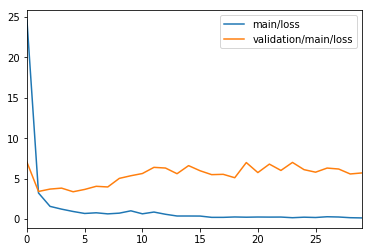

In [25]:
# 損失関数(loss)
result[['main/loss', 'validation/main/loss']].plot()

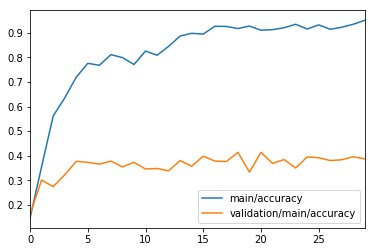

In [26]:
# 精度(accuracy)
result[['main/accuracy', 'validation/main/accuracy']].plot()

In [0]:
class GoogleNet(chainer.Chain):

    def __init__(self, n_out=20):
        super().__init__()
        with self.init_scope():
            self.base = L.GoogLeNet()
            self.fc = L.Linear(None, n_out)

    def __call__(self, x):
        h = self.base(x, layers=['pool5']) # どこまでを使うか
        h = self.fc(h['pool5']) # うけつぐ層を指定
        return h

In [0]:
# 乱数のシード固定用の関数
def reset_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    if chainer.cuda.available:
        chainer.cuda.cupy.random.seed(seed)

In [0]:
# CPUとGPU関連のシードをすべて固定
reset_seed(0)

In [30]:
# インスタンス化
googlenet = GoogleNet()

Now loading caffemodel (usually it may take few minutes)


In [0]:
model = L.Classifier(googlenet) 

In [32]:
gpu_id = 0 # 使用したGPUに割り振られているID
model.to_gpu(gpu_id)

In [33]:
# Optimizerの定義とmodelとの紐づけ
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [0]:
# 追加
# 学習済みパラメータを固定
model.predictor.base.disable_update()

In [0]:
batchsize = 128
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

In [0]:
from chainer import training
from chainer.training import extensions

epoch = 30

updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

trainer = training.Trainer(updater, (epoch, 'epoch'), out='drive/My Drive/kikagaku/longterm/UenoAnimalClassfication/result/animal_googlenet0713')

# バリデーション用のデータで評価
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))

# 学習結果の途中を表示する
trainer.extend(extensions.LogReport(trigger=(1, 'epoch'), log_name='dog-cat_googlenet'))

# １エポックごとに結果をlogファイルに出力させる
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

In [37]:
# GPU使用状況の確認
!nvidia-smi

Sat Jul 13 10:01:41 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    30W /  70W |    943MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [39]:
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.402778       0.678928                  2.12883     1.09113               14.1594       
2           0.75           0.763383                  0.837435    0.74033               26.1619       
3           0.810662       0.786929                  0.598514    0.647324              38.3308       
4           0.846788       0.813404                  0.488092    0.605087              51.2746       
5           0.87454        0.817925                  0.417111    0.585438              63.8068       
6           0.897518       0.822193                  0.355228    0.575262              76.2753       
7           0.905816       0.807798                  0.318274    0.563368              89.0882       
8           0.922794       0.827799                  0.272763    0.551195              101.265       
9           0.929228       0.811089                  0.251283    0.554876           

In [40]:
# GPU使用状況の確認
!nvidia-smi

Sat Jul 13 10:10:01 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    46W /  70W |   6595MiB / 15079MiB |     23%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [43]:
import json
import pandas as pd
with open('drive/My Drive/kikagaku/longterm/UenoAnimalClassfication/result/animal_googlenet0713/dog-cat_googlenet') as f:
    result = pd.DataFrame(json.load(f))

# 結果の表示
result

,elapsed_time,epoch,iteration,main/accuracy,main/loss,validation/main/accuracy,validation/main/loss
0,14.159377,1,18,0.402778,2.128829,0.678928,1.091130
1,26.161919,2,35,0.750000,0.837435,0.763383,0.740330
2,38.330812,3,52,0.810662,0.598514,0.786929,0.647324
3,51.274577,4,70,0.846788,0.488092,0.813404,0.605087
4,63.806835,5,87,0.874540,0.417111,0.817925,0.585438
5,76.275319,6,104,0.897518,0.355228,0.822193,0.575262
6,89.088185,7,122,0.905816,0.318274,0.807798,0.563368
7,101.265044,8,139,0.922794,0.272763,0.827799,0.551195
8,113.299454,9,156,0.929228,0.251283,0.811089,0.554876
9,125.409939,10,173,0.934283,0.231882,0.820602,0.542667


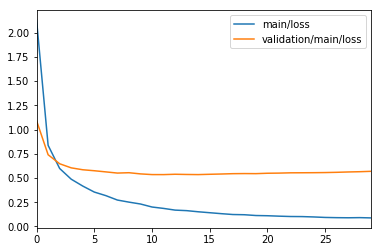

In [44]:
# 損失関数(loss)
result[['main/loss', 'validation/main/loss']].plot()

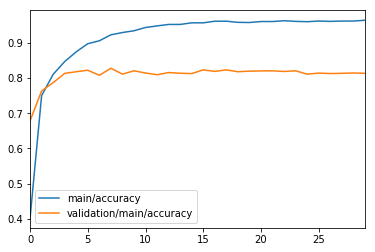

In [45]:
# 精度(accuracy)
result[['main/accuracy', 'validation/main/accuracy']].plot()